In [1]:
import sys,os
import numpy as np
import pandas as pd
import random

sys.path.append('../')

from unpast.utils.method import prepare_input_matrix
from unpast.utils.io import read_bic_table, write_bic_table
from unpast.utils.consensus import make_consensus_biclusters
from unpast.run_unpast import unpast

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
passed_ids = pd.read_csv("../../data/preprocessed_v6/passed_gene_ids.txt",header=None)
passed_ids = passed_ids[0].values
passed_ids = [ x for x in sorted(set(passed_ids)) if not x =='pk' ]
bic_dir = "../../all_cancers_results_latest/"
suffix = ".bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv"

exprs_dir = "../../data/PanCan/"
len(passed_ids)

26296

In [3]:
analysis_seed = 0
n_runs = 5
seeds = []
random.seed(analysis_seed)
for i in range(n_runs):
    seeds.append(random.randint(0,1000000))

print("generate ",n_runs," seeds",seeds)

generate  5  seeds [885440, 403958, 794772, 933488, 441001]


# Runnig UnPaSt five times and making consensus for each cancer
* this is a time-consuming step 
* skip next two tabs and load pre-computed biclusters if available

In [ ]:
# running UnPaST for each cancer (time consuming)
for f in sorted(os.listdir(exprs_dir)):
    if f.endswith(".exprs.tsv.gz") and f.replace(".exprs.tsv.gz",""): # 
        cancer = f.replace(".exprs.tsv.gz","")
        
        exprs_file = cancer+".exprs.tsv.gz"
        exprs = pd.read_csv(exprs_dir+"/"+exprs_file,sep = "\t",index_col=0)

        exprs = exprs.loc[passed_ids,:]
        exprs.to_csv(exprs_dir+"/no_pseudo/"+cancer+"_26K.exprs.tsv.gz", sep = "\t")
        basename = cancer
        exprs_file  = exprs_dir+"/no_pseudo/"+cancer+"_26K.exprs.tsv.gz"
        
        print(cancer, exprs_file, exprs.shape)
        for seed in seeds:
            results = unpast(exprs_file, basename,
                                  rpath="/home/olya/anaconda3/envs/r4_env/bin/",
                                  out_dir=bic_dir,
                                  load=False,
                                  seed = seed,
                                  verbose = False)

            print("\tn=%s"%results.shape[0])

In [ ]:
# reading UnPaSt results and making consensus biclusters
for f in sorted(os.listdir(exprs_dir)):
    if f.endswith(".exprs.tsv.gz") and f.replace(".exprs.tsv.gz",""): # 
        cancer = f.replace(".exprs.tsv.gz","")
        
        basename = cancer
        exprs_file  = exprs_dir+"/no_pseudo/"+cancer+"_26K.exprs.tsv.gz"
        exprs = pd.read_csv(exprs_file,sep = "\t",index_col=0)
        exprs_z = prepare_input_matrix(exprs, min_n_samples=5,ceiling=3)

        biclusters = []
        for seed in seeds:
            bic_file = bic_dir+cancer+".seed="+str(seed)+suffix
            b = read_bic_table(bic_file)
            b.index = ["seed="+str(seed)+"_"+str(x) for x in b.index.values ]
            biclusters.append(b)
        cb = make_consensus_biclusters(biclusters,
                                       exprs_z,
                                       seed = analysis_seed,
                                       verbose = True,
                                       plot = False
                                      )
        cb.index = [cancer+"_"+str(x) for x in cb.index.values]
        write_bic_table(cb, bic_dir+cancer+"_consensus.seed="+str(analysis_seed)+suffix)
        print(cancer, cb.shape[0], exprs.shape)

# Reading consensus biclusters and expressions  for each cancer

In [4]:
stats = {}
bics = {}
for f in sorted(os.listdir(exprs_dir)):
    if f.endswith(".exprs.tsv.gz"): # 
        cancer = f.replace(".exprs.tsv.gz","")
        exprs_file  = exprs_dir+"/no_pseudo/"+cancer+"_26K.exprs.tsv.gz"
        exprs = pd.read_csv(exprs_file,sep = "\t",index_col=0)
        b = read_bic_table(bic_dir+cancer+"_consensus.seed="+str(analysis_seed)+suffix)
        b["cancer"] = cancer
        bics[cancer] = b
        #print(cancer, exprs.shape[1],b.shape[0])
        stats[cancer] = {"n_samples":exprs.shape[1],
                         "n_biclusters":b.shape[0]}
stats = pd.DataFrame.from_dict(stats).T

In [5]:
# https://cancerci.biomedcentral.com/articles/10.1186/s12935-020-01678-x/figures/2
ecto = ["BRCA","HNSC","GBM","LGG","SKCM","PCPG","UVM"]
meso=["OV","PRAD","LAML","DLBC","UCS","UCEC",
      "KICH","KIRC","KIRP","MESO","TGCT","SARC",
     "CESC","ACC"]
# ? ESCA -? Esophageal carcinoma
ento=["READ","COAD","LUAD","LUSC","THYM","THCA","STAD",
      "PAAD","LIHC","BLCA","CHOL",]

stats["germ_layer"] = ""
stats.loc[ecto,"germ_layer"] = "ecto"
stats.loc[meso,"germ_layer"] = "meso"
stats.loc[ento,"germ_layer"] = "ento"
stats

,n_samples,n_biclusters,germ_layer
ACC,77,1270,meso
BLCA,407,872,ento
BRCA,1098,285,ecto
CESC,306,484,meso
CHOL,36,504,ento
COAD,288,275,ento
DLBC,47,472,meso
ESCA,182,400,
GBM,165,1289,ecto
HNSC,520,495,ecto


<Figure size 500x500 with 0 Axes>

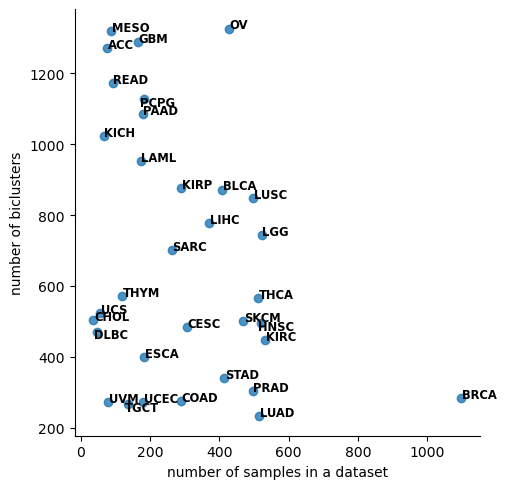

In [6]:
plt.figure(figsize=(5,5))

stats["cancer"]=stats.index
sns.lmplot(data=stats, 
           x="n_samples",
           y="n_biclusters",
           fit_reg=False)#, hue='germ_layer')

for line in range(0,stats.shape[0]):
    if stats.index[line] not in ["PCPG","DLBC","HNSC","TGCT"]:
        plt.text(stats.n_samples[line]+2, stats.n_biclusters[line],
                     stats.index[line], horizontalalignment='left', size='small', color='black', weight='semibold')
    else:
        plt.text(stats.n_samples[line]-10, stats.n_biclusters[line]-20,
                     stats.index[line], horizontalalignment='left', size='small', color='black', weight='semibold')

plt.xlabel("number of samples in a dataset")
plt.ylabel("number of biclusters")
plt.savefig(bic_dir+"/bic_number_vs_sample_size.svg")
plt.show()

In [7]:
from scipy.stats import pearsonr
pearsonr(stats["n_samples"].values, stats["n_biclusters"].values)

PearsonRResult(statistic=-0.3059645833445408, pvalue=0.08333334927553021)

In [8]:
# without BRCA
pearsonr(stats.loc[stats["cancer"]!="BRCA","n_samples"].values,
        stats.loc[stats["cancer"]!="BRCA","n_biclusters"].values)

PearsonRResult(statistic=-0.2358045536151381, pvalue=0.19385712226003962)

### Average pairwise correlation

In [9]:
stats["avg_corr"] = 0
stats_corr = {}
for cancer in stats.index.values:
    #print(cancer)
    avg_corrs = []
    exprs_file  = exprs_dir+"/no_pseudo/"+cancer+"_26K.exprs.tsv.gz"
    exprs = pd.read_csv(exprs_file,sep = "\t",index_col=0)
    exprs_z = prepare_input_matrix(exprs, min_n_samples=5,ceiling=3)
    for bic_id in bics[cancer].index:
        genes = bics[cancer].loc[bic_id,"genes"]
        e = exprs_z.loc[list(genes),:]
        n = len(genes)
        avg_corr = np.abs(np.triu(e.T.corr(),k=1)).sum().sum()*2/(n**2-n)
        avg_corrs.append(avg_corr)
        stats_corr[bic_id] = { "cancer":cancer,
                                "n_genes":len(genes),
                                "n_samples": bics[cancer].loc[bic_id,"n_samples"],
                                "SNR": bics[cancer].loc[bic_id,"SNR"],
                                "avg_corr": avg_corr}
    stats.loc[cancer,"avg_corr"] = np.mean(avg_corrs)
stats_corr  = pd.DataFrame.from_dict(stats_corr ).T
stats_corr

,cancer,n_genes,n_samples,SNR,avg_corr
ACC_0,ACC,4,7,4.189811,0.472651
ACC_1,ACC,2,6,4.067015,0.718106
ACC_2,ACC,2,10,4.026932,0.339168
ACC_3,ACC,3,6,3.858772,0.629171
ACC_4,ACC,3,7,3.734821,0.301432
...,...,...,...,...,...
UVM_269,UVM,5,27,1.362595,0.312578
UVM_270,UVM,11,16,1.326295,0.240575
UVM_271,UVM,3,15,1.323764,0.292805
UVM_272,UVM,3,13,1.308304,0.439374


<Figure size 500x500 with 0 Axes>

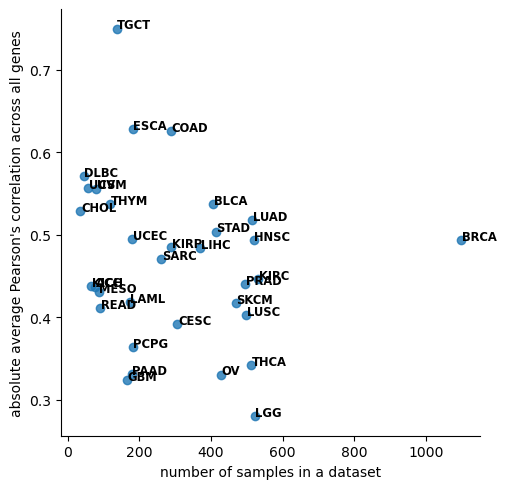

In [10]:
plt.figure(figsize=(5,5))

sns.lmplot(data=stats, 
           x="n_samples",
           y="avg_corr",
           fit_reg=False)#, hue='germ_layer')
for line in range(0,stats.shape[0]):
    if stats.index[line] not in ["PCPG","DLBC","HNSC","TGCT"]:
        plt.text(stats.n_samples[line]+2, stats.avg_corr[line],
                     stats.index[line], horizontalalignment='left', size='small', color='black', weight='semibold')
    else:
        plt.text(stats.n_samples[line]-0, stats.avg_corr[line]-0,
                     stats.index[line], horizontalalignment='left', size='small', color='black', weight='semibold')
        
plt.xlabel("number of samples in a dataset")
plt.ylabel("absolute average Pearson's correlation across all genes")

plt.show()

In [11]:
stats_corr["avg_corr"].min(),stats_corr["avg_corr"].mean(),stats_corr["avg_corr"].max() 

(0.044673659575878454, 0.43712355007581355, 1.0)

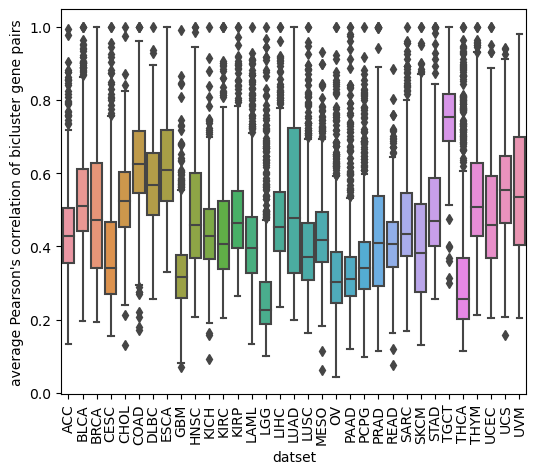

In [12]:
plt.figure(figsize=(6,5))

sns.boxplot(data=stats_corr, 
           x="cancer",
           y="avg_corr")#, hue='germ_layer')
plt.xlabel("datset")
plt.ylabel("average Pearson's correlation of bicluster gene pairs")
plt.xticks(rotation=90)
plt.savefig(bic_dir+"/avg_corrs.svg")
plt.show()

In [ ]:
#stats_corr.loc[stats_corr["cancer"]=="BRCA",:].sort_values(by = ["avg_corr"],ascending = [True]).head(60)

### Plot example biclusters 

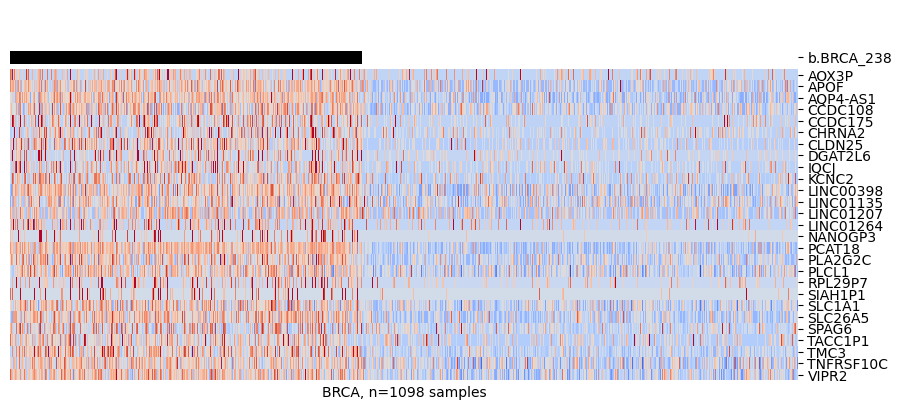

In [46]:
from unpast.utils.figs import draw_heatmap2
from unpast.utils.method import prepare_input_matrix

i = ["BRCA_238"]  
cancer = "BRCA"

exprs = pd.read_csv(exprs_dir+cancer+".exprs.tsv.gz",index_col=0,sep="\t")
exprs_z = prepare_input_matrix(exprs)
bic_file = bic_dir+cancer+"_consensus.seed="+str(analysis_seed)+suffix
biclusters = read_bic_table(bic_file)
b = biclusters.loc[i,:]

h = min(max(0.15*(b["n_genes"].sum()),3),20)
row_labels = True
if h>=20:
    row_labels = False

tmp = draw_heatmap2(exprs_z ,b,
              bicluster_colors= "black",
              figsize = (10,h), 
              dendrogram_ratio=(0.1,0.1),
              colors_ratio=(0.0, 0.15/h),
              bic_prefix = "b.",
              xlabel='%s, n=%s samples'%(cancer,exprs.shape[1]),
              #highlight_row_labels=shared_genes,
              no_cbar=True,
              col_labels = False,
              row_labels = row_labels,
              no_row_colors = True,
              cluster_rows=False
             )
if h>5 and h<20:
    tmp[0].ax_heatmap.set_yticklabels(tmp[0].ax_heatmap.get_yticklabels(),fontdict={"size":7})

# Find similar biclusters in different cancers

* find biclusters significantly overlapping in genes
* find modules in Jaccard similarity matrix
* for each module, extract genes in 50%+ biclusters
* comapre cancer by matched biclusters

In [13]:
from unpast.utils.eval import find_best_matching_biclusters
import numpy as np

In [14]:
bg_gene_names = sorted(passed_ids)
exprs_file = cancer+".exprs.tsv.gz"
exprs = pd.read_csv(exprs_dir+"/"+exprs_file,sep = "\t",index_col=0)
exprs = exprs.loc[bg_gene_names,:]
print("Background:", len(bg_gene_names))

Background: 26296


### pairwise  bicluster similarity by genes

In [ ]:
def sim_from_make_consensus_biclusters(biclusters,
                                       run="cancer",
                                       similarity = "genes",
                                       sizes = (exprs.shape[0],0),
                                       p=0.05,
                                       min_n_genes=2):
    runs = sorted(set(biclusters[run].values))
    n_runs = len(runs)
    n_bics = biclusters.shape[0]
    bic_ids = biclusters.index.values
    J_heatmap = pd.DataFrame(np.zeros((n_bics, n_bics)), index=bic_ids, columns=bic_ids)

    # add only best matches to Jaccard similarity matrix
    avg_J_sim = {}
    for i in range(n_runs):
        # bicluster is always the best match of itself,
        # similarity matrix block for output of a biclustering method w. itself is an identity matrix
        bics1 = biclusters.loc[biclusters[run] == runs[i], :]
        J_heatmap.loc[bics1.index.values, bics1.index.values] = np.identity(
            bics1.shape[0]
        )
        avg_J_sim[i] = {i: 1}
        print(runs[i])
        for j in range(n_runs):
            if i != j:
                bics2 = biclusters.loc[biclusters[run] == runs[j], :]
                # find best matches between bics1 and bics2
                bm = find_best_matching_biclusters(
                    bics1,
                    bics2,
                    sizes ,
                    by=similarity,
                    min_g=min_n_genes,
                    adj_pval_thr=p,
                )
                bm = bm.dropna()
                if bm.shape[0] > 0:
                    avg_J_sim[i][j] = np.mean(bm["J"])
                    df = bm.loc[:, ["bm_id", "J"]]
                    for row in df.iterrows():
                        J_heatmap.loc[row[0], row[1]["bm_id"]] += row[1]["J"] / 2
                        J_heatmap.loc[row[1]["bm_id"], row[0]] += row[1]["J"] / 2
    return J_heatmap

biclusters = pd.concat(list(bics.values()))
sim = sim_from_make_consensus_biclusters(biclusters, run="cancer")
matched_bic_ids = list(sim.index[sim.sum(axis=1)>1].values)
sim = sim.loc[matched_bic_ids,matched_bic_ids]
sim.to_csv(bic_dir+"/J_sim_all_biclusters.tsv",sep = "\t",)

sim[sim<0.1] = 0 
matched_bic_ids = list(sim.index[sim.sum(axis=1)>1].values)
sim = sim.loc[matched_bic_ids,matched_bic_ids]
sim.to_csv(bic_dir+"/J_sim_all_biclusters_more0.1.tsv",sep = "\t",)
J_heatmap = 0
sim.shape

In [15]:
#sim = pd.read_csv(bic_dir+"/J_sim_all_biclusters_more0.1_old.tsv",sep = "\t",index_col = 0)
#sim.shape

(6465, 6465)

In [16]:
from unpast.utils.method import run_Louvain, zscore
modules, not_clustered, best_cutoff = run_Louvain(sim,
                                                  similarity_cutoffs=[0.33],
                                                  plot= False)

	Running Louvain ...
		modularity: newman
	Louvain runtime: modules detected in 4.17 s.
	modules: 833, not clustered features 1630 
		similarity cutoff: 0.33 modularity: 0.993


### gene families and chr locations (HGNC)

In [17]:
gene_info  = pd.read_csv("../../data/preprocessed_v6/HGNC_gene_info.tsv",sep = "\t",index_col=1)
gene_info = gene_info.loc[:,["Chromosome","Gene group name"]]
gene_info["chrom2"] = gene_info["Chromosome"].apply(lambda x: x.split(".")[0])
gene_info = gene_info.fillna("NA")
add_genes = set(passed_ids).difference(gene_info.index.values)
gene_info = gene_info.T
gene_info.loc[["Chromosome","chrom2"],sorted(add_genes)] = "NA"
gene_info.loc[["Gene group name"],sorted(add_genes)] = "NA"
gene_info = gene_info.T
gene_info["Gene group name"] = gene_info["Gene group name"].apply(lambda x : set([elem for elem in x.split("|") if not elem == "NA"]))
gene_info.head(2)

,Chromosome,Gene group name,chrom2
Approved symbol,,,
A1BG,19q13.43,{Immunoglobulin like domain containing},19q13
A1BG-AS1,19q13.43,{Antisense RNAs},19q13


In [18]:
gene2group = gene_info["Gene group name"].to_dict()
gene2chr = gene_info["Chromosome"].to_dict()
gene2chr2 = gene_info["chrom2"].to_dict()

### Annotating groups of similar biclusters

In [19]:
def f(genes):
    s = set([])
    for g in genes:
        s|= set( [x for x in gene2group[g] if not x == "NA" ])
    return s

pancan = []
for m in modules:
    
    count_genes = {} # in how many cancers a gene is biclustered
    count_cancers = set([])
    for bic in m:
        c = bic.split("_")[0]
        count_cancers.add(c)
        for g in bics[c].loc[bic,"genes"]:
            if g in count_genes.keys():
                count_genes[g].add(c)
            else:
                count_genes[g] = set([c])
                
    count_genes = pd.Series(count_genes).apply(lambda x: len(x)).sort_values()
    passed_genes = count_genes[count_genes>len(count_cancers)/2].index.values

    if len(passed_genes)>0:
        pancan.append({"n_genes":len(passed_genes),"genes":set(passed_genes),
                  "n_cancers":len(count_cancers),"cancers":count_cancers,"biclusters":set(m)})
pancan = pd.DataFrame.from_records(pancan)
pancan['gene_groups'] = pancan["genes"].apply(lambda genes: f(genes))
pancan['loc'] = pancan["genes"].apply(lambda genes: set([gene2chr2[x] for x in genes]).difference(set(["NA"])))
pancan['n_loc'] = pancan['loc'].apply(lambda x: len([elem for elem in x if not elem == ""]))
pancan['n_groups'] = pancan['gene_groups'].apply(lambda x: len([elem for elem in x if not elem == ""]))

pancan = pancan.sort_values(by= ["n_cancers","n_genes"],ascending = [False,False])
print(pancan.shape[0])

833


## Select the largest and most frequent recurrent biclusters

In [20]:
reccurrent_bics = pancan.loc[pancan["n_loc"]>1,:].loc[pancan["n_groups"]>1,:].loc[pancan["n_cancers"]>=5,:].loc[pancan["n_genes"]>=20,:]
reccurrent_bics 

,n_genes,genes,n_cancers,cancers,biclusters,gene_groups,loc,n_loc,n_groups
0,26,"{TXLNGY, DDX3Y, FAM224B, ZNF736P9Y, PRKY, BCOR...",29,"{LGG, STAD, BLCA, CHOL, UCEC, CESC, UVM, KIRC,...","{UVM_46, PAAD_167, HNSC_206, LIHC_5, HNSC_8, P...",{Long non-coding RNAs with non-systematic symb...,"{Yp11, Yq11}",2,18
26,93,"{HNRNPA1P70, IGKV1D-12, IGKV1D-33, IGLV8-61, I...",22,"{LGG, STAD, BLCA, OV, PRAD, UCEC, CESC, KIRC, ...","{KIRC_379, UCEC_227, LUSC_665, PAAD_546, OV_98...","{Adenosine deaminase family, Immunoglobulin ka...","{13q14, 14q32, 15q11, 2p11, 16p11, 2p12, 1p13,...",12,8
128,114,"{SPIC, TRAV18, CLEC6A, TRBV2, TRBV6-6, TCRBV11...",10,"{LGG, HNSC, BLCA, SKCM, LUAD, PRAD, LUSC, CESC...","{PRAD_281, BLCA_751, CESC_395, SKCM_382, HNSC_...",{Long non-coding RNAs with non-systematic symb...,"{6q27, 15q11, 4q27, 11q14, 14q11, 17q12, 4q21,...",28,23
259,52,"{APOH, MBL2, AMBP, AGXT, CFHR2, FABP1, KNG1, A...",5,"{BLCA, SKCM, PRAD, CESC, SARC}","{PRAD_20, CESC_76, BLCA_276, SKCM_8, SARC_269}","{Gla domain containing, Neuropeptides, Apolipo...","{11p11, 17q24, 16p12, 17p13, 5q31, 4q13, Xq27,...",31,24
279,48,"{SNORD15A, SNORD89, RN7SL5P, RN7SKP71, SNORA37...",5,"{LGG, OV, PCPG, PRAD, THCA}","{THCA_77, OV_430, PRAD_52, LGG_355, PCPG_58}","{Variant U1 small nuclear RNAs, Small nuclear ...","{10q24, 2q11, 17q24, 18q21, 17p13, 11p15, 2p25...",32,12


In [21]:
# HER2+ is was found but excluded bc all genes are from one locus
pancan[pancan["genes"].apply(lambda x: "ERBB2" in x)]

,n_genes,genes,n_cancers,cancers,biclusters,gene_groups,loc,n_loc,n_groups
501,4,"{ERBB2, PGAP3, MIEN1, STARD3}",3,"{BRCA, ESCA, STAD}","{STAD_63, BRCA_42, ESCA_231}",{StAR related lipid transfer domain containing...,{17q12},1,5


## plotting average z-scores of a recurrent biclusters

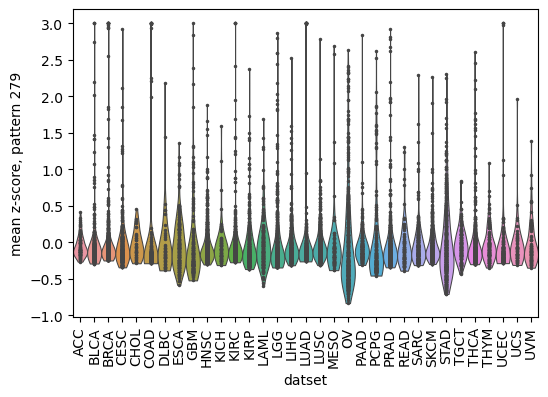

In [22]:
cancers = stats.index.values
#in all cancers
for ndx in [279]:#recurrent_biclusters.index.values:
    genes = sorted(pancan.loc[ndx,"genes"])
    cs = sorted(pancan.loc[ndx,"cancers"])
    data = []
    for cancer in cancers:
        exprs = pd.read_csv(exprs_dir+cancer+".exprs.tsv.gz",index_col=0,sep="\t").loc[genes,:]
        e_z_mean = prepare_input_matrix(exprs,ceiling=3).mean()
        df = pd.DataFrame.from_dict({"mean_z":e_z_mean, "pattern":ndx, "cancer":cancer,"detected":cancer in cs})
        data.append(df)
        
    data=pd.concat(data)
    plt.figure(figsize=(6,4))
    sns.violinplot(data=data,x="cancer",y="mean_z",
                   scale ="width", width=1,
                   cut = 0,
                   inner="point",
                   #hue = "detected", dodge=False, palette={True:"red",False:"white"},
                   linewidth =0.75
                  )
    plt.xlabel("datset")
    plt.ylabel("mean z-score, pattern %s"%ndx)
    plt.xticks(rotation=90)
    #plt.savefig(bic_dir+"/avg_corrs.svg")
    plt.show()

## Heatmaps for recurrent biclusters 

In [24]:
cluster_id = 279
shared_genes = pancan.loc[cluster_id,"genes"]
print("\t".join(sorted(shared_genes)))

HIST1H4A	RN7SKP203	RN7SKP255	RN7SKP71	RN7SL5P	RNA5S9	RNA5SP202	RNU4-1	RNU5A-1	RNU5B-1	RNU5E-1	RNVU1-7	RNY1	RNY3	SCARNA1	SCARNA3	SNORA12	SNORA14B	SNORA16A	SNORA23	SNORA24	SNORA34	SNORA35	SNORA37	SNORA38B	SNORA45A	SNORA49	SNORA54	SNORA55	SNORA5A	SNORA5C	SNORA71A	SNORA71D	SNORA76C	SNORA79	SNORA7A	SNORA7B	SNORA80A	SNORA80B	SNORA84	SNORD10	SNORD118	SNORD15A	SNORD15B	SNORD8	SNORD89	SNORD94	Telomerase-vert


In [25]:
print("\t".join(pancan.loc[cluster_id,"biclusters"]))

THCA_77	OV_430	PRAD_52	LGG_355	PCPG_58


In [26]:
#c1 = set(stats.index.values)
#c2 = set([x.split("_")[0] for x in pancan.loc[cluster_id,"biclusters"]])  
#c1.difference(c2)

### Load information on the batches

In [31]:
# from GDC
batch_dir= "../../data/preprocessed_v6/tcga_batches/"
s = pd.read_csv(batch_dir+"/sample.csv.gz",sep ="\t")
s.set_index("samples.submitter_id")
s = s.loc[:,["project.project_id","samples.submitter_id","samples.tissue_type","samples.is_ffpe","samples.preservation_method"]]
s = s.loc[s["samples.tissue_type"]=="Tumor",:]
s = s.drop_duplicates()
s = s.set_index("samples.submitter_id")
s.head(3)

,project.project_id,samples.tissue_type,samples.is_ffpe,samples.preservation_method
samples.submitter_id,,,,
TCGA-AB-2986-03A,TCGA-LAML,Tumor,false,Unknown
TCGA-E1-A7YE-01Z,TCGA-LGG,Tumor,true,FFPE
TCGA-E1-A7YE-01A,TCGA-LGG,Tumor,false,OCT


In [32]:
# data download from https://bioinformatics.mdanderson.org/MQA/ 
dfs = []
for f in os.listdir(batch_dir):
    if not "." in f:
        df = pd.read_csv(batch_dir+f+"/current/original/batches.tsv",sep ="\t")
        df["sample"] = df["aliquot_barcode"].apply(lambda x : "-".join(x.split("-")[:4]))
        df.set_index("sample",inplace=True)
        dfs.append(df)
dfs = pd.concat(dfs)
dfs.head(3)

,aliquot_barcode,batch_id,sample_type_name,ship_date,source_center,tissue_source_site
sample,,,,,,
TCGA-KL-8323-01A,TCGA-KL-8323-01A-21R-2315-07,226.67.0,Primary Tumor,2012-06-11,22,KL
TCGA-KL-8324-01A,TCGA-KL-8324-01A-11R-2315-07,226.67.0,Primary Tumor,2012-06-11,22,KL
TCGA-KL-8324-11A,TCGA-KL-8324-11A-01R-2315-07,226.67.0,Solid Tissue Normal,2012-06-11,22,KL


In [33]:
# data downloaded from Xena
batches = pd.read_csv(batch_dir+"EB++GeneExpAnnotation.tsv.gz", sep = "\t")
batches["plate"] = batches["SampleID"].apply(lambda x : x.split("-")[5])
batches["sample"] = batches["SampleID"].apply(lambda x : "-".join(x.split("-")[:4]))
batches["TSS"] =  batches["SampleID"].apply(lambda x : x.split("-")[1])
batches = batches.loc[:,["plate","TSS","sample"]].drop_duplicates("sample")
batches.set_index("sample",inplace=True)
batches = batches.merge(dfs,left_index=True,right_index=True)
batches = batches.merge(s,left_index=True,right_index=True)
batches["sample"] = [x[:-1] for x in batches.index]
batches.index =range(batches.shape[0])
batches = batches.drop_duplicates(["sample"])
batches.set_index("sample",inplace=True)
batches

,plate,TSS,aliquot_barcode,batch_id,sample_type_name,ship_date,source_center,tissue_source_site,project.project_id,samples.tissue_type,samples.is_ffpe,samples.preservation_method
sample,,,,,,,,,,,,
TCGA-02-0047-01,1849,02,TCGA-02-0047-01A-01R-1849-01,1.96.0,Primary Tumor,2011-06-27,22,2,TCGA-GBM,Tumor,false,Unknown
TCGA-02-0055-01,1849,02,TCGA-02-0055-01A-01R-1849-01,1.96.0,Primary Tumor,2011-06-27,22,2,TCGA-GBM,Tumor,false,Unknown
TCGA-02-2483-01,1849,02,TCGA-02-2483-01A-01R-1849-01,26.75.0,Primary Tumor,2011-06-27,22,2,TCGA-GBM,Tumor,false,Unknown
TCGA-02-2485-01,1849,02,TCGA-02-2485-01A-01R-1849-01,26.75.0,Primary Tumor,2011-06-27,22,2,TCGA-GBM,Tumor,false,Unknown
TCGA-02-2486-01,1849,02,TCGA-02-2486-01A-01R-1849-01,26.75.0,Primary Tumor,2011-06-27,22,2,TCGA-GBM,Tumor,false,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ZS-A9CF-02,A38B,ZS,TCGA-ZS-A9CF-02A-11R-A38B-07,399.48.0,Recurrent Tumor,2014-03-26,23,ZS,TCGA-LIHC,Tumor,false,Unknown
TCGA-ZS-A9CG-01,A37K,ZS,TCGA-ZS-A9CG-01A-11R-A37K-07,384.50.0,Primary Tumor,2014-02-26,23,ZS,TCGA-LIHC,Tumor,false,OCT
TCGA-ZT-A8OM-01,A42S,ZT,TCGA-ZT-A8OM-01A-11R-A42S-07,431.29.0,Primary Tumor,2014-06-18,23,ZT,TCGA-THYM,Tumor,false,Unknown


## Plot recurrent biclusters 
* Y-chr-specific expression in female cancers 
* s259 and s279

In [47]:
color_dict = {"sex":{"female":"pink","male":"cyan"}}
# Y chr in female samples
i = ["BRCA_10","BRCA_39"]  
i = ["UCEC_30"]
i = ["CESC_248"]

# Y chom 
i = ["STAD_1","STAD_54"]
i = ["COAD_6","COAD_38"]

# recurrent bicluster examples
#s259 ["BLCA_276","CESC_76","PRAD_20","SARC_269","SKCM_8"] # A37K A311 A32O A33R A38B A41I A38B A33J
#i = ["SKCM_8"]
# s279 LGG_355 OV_430 PCPG_58 PRAD_52 THCA_77
i = ["SKCM_8"]

cancer = i[0].split("_")[0]

exprs = pd.read_csv(exprs_dir+cancer+".exprs.tsv.gz",index_col=0,sep="\t")
exprs_z = prepare_input_matrix(exprs)
bic_file = bic_dir+cancer+"_consensus.seed="+str(analysis_seed)+suffix
biclusters = read_bic_table(bic_file)
b = biclusters.loc[i,:]

In [48]:
# "BRCA_10" includes all male biclusters 
#print(set(a.loc[a["sex"]=="male",:].index.values) == biclusters.loc["BRCA_10","samples"])
#biclusters.loc["BRCA_10","n_samples"]

In [49]:
"""for bic in ["BLCA_276","CESC_76","PRAD_20","SARC_269","SKCM_8"]:
    cancer = bic.split("_")[0]
    bic_file = bic_dir+cancer+"_consensus.seed="+str(analysis_seed)+suffix
    s = read_bic_table(bic_file).loc[bic,"samples"]
    N = exprs = pd.read_csv(exprs_dir+cancer+".exprs.tsv.gz",index_col=0,sep="\t").shape[1]
    print(bic, len(s), "%.2f"%(len(s)/N*100))
    print("\t01:",len([x for x in s if "01" in x ]))
    print("\t06:",len([x for x in s if "06" in x]))"""

'for bic in ["BLCA_276","CESC_76","PRAD_20","SARC_269","SKCM_8"]:\n    cancer = bic.split("_")[0]\n    bic_file = bic_dir+cancer+"_consensus.seed="+str(analysis_seed)+suffix\n    s = read_bic_table(bic_file).loc[bic,"samples"]\n    N = exprs = pd.read_csv(exprs_dir+cancer+".exprs.tsv.gz",index_col=0,sep="\t").shape[1]\n    print(bic, len(s), "%.2f"%(len(s)/N*100))\n    print("\t01:",len([x for x in s if "01" in x ]))\n    print("\t06:",len([x for x in s if "06" in x]))'

In [52]:
# read sample annotation and plate ids
a = pd.read_csv(exprs_dir+"/"+cancer+".annotation.tsv.gz",index_col=0,sep="\t").loc[:,["sex"]]
d1 = {1:"female",0:"male"}
a = a.applymap(lambda x: d1[x])

shared_samples = sorted(set(a.index).intersection(batches.index))
print(a.shape[0]-len(shared_samples),"samples without batch information")
a["plate"] = "NA"
a.loc[shared_samples, "plate"] = batches.loc[shared_samples,"plate"] 

1 samples without batch information


In [54]:
# define plates significantly associated with biclsuter
from statsmodels.stats.multitest import multipletests
from scipy.stats import fisher_exact
def check_association_with_batch(bic_samples,annot=a, batch_col = "plate"):
    # find plates significantly associated with a biclsuter
    bic_samples = bic_samples.intersection(set(annot.index.values))
    df ={}
    for batch in set(a[batch_col].values).difference(set(["NA"])):
        b = set(a.loc[a[batch_col]==batch,:].index)
        o = b.intersection(bic_samples)
        bg =a.shape[0]
        table = np.array([[len(o), len(b)-len(o)],
                          [len(bic_samples)-len(o), bg-len(bic_samples)-len(b)+len(o)]])
        #try:
        OR, p_val = fisher_exact(table, alternative='greater')
        df[batch]={"p_val":p_val,"OR":OR,"o":len(o),batch_col:len(b)}
        #except:
        #print(table)
    df = pd.DataFrame.from_dict(df).T.sort_values("p_val")
    rejected, corrected_pvals, _, _ = multipletests(df["p_val"], alpha=0.05, method='fdr_bh')
    df["adj_pval"] = corrected_pvals
    df = df.sort_values("adj_pval")
    return df 

bic_samples = biclusters.loc[i[-1],"samples"]

# print associated plates
df  = check_association_with_batch(bic_samples,annot=a)
df.loc[df["adj_pval"]<0.05,:]

,p_val,OR,o,plate,adj_pval
A37K,0.000015,7.505882,11.0,46.0,0.000244
A311,0.000057,10.974359,7.0,20.0,0.000456


In [55]:
# check all batch types
signif_v = []
for v in ["plate","ship_date","samples.preservation_method"]: # batches to check
    a[v] = "NA"
    a.loc[shared_samples,v] = batches.loc[shared_samples,v]
    if len(set(a[v].values).difference(set(["NA"]))) > 1:
        for bic_id in b.index.values:
            df = check_association_with_batch(b.loc[bic_id,"samples"],
                                              annot=a,
                                              batch_col=v)
            signif_batches = sorted(df.loc[df["adj_pval"]<=0.05,:].index.values)
            if len(signif_batches )>0:
                print("bicluster:",b.loc[bic_id,"n_samples"])
                signif_v.append(v)
                print(df.loc[df["adj_pval"]<=0.05,:])
                #
                for batch_id in df.loc[df["adj_pval"]<=0.05,:].index.values:
                    print(batch_id)
                    print(batches.loc[batches[v]==batch_id,[v,"project.project_id"]].groupby("project.project_id").agg("count"))
                    print()
                
                # colorblind-friendly palette for batches 
                color_dict[v] = dict(zip(sorted(set(a[v].values)),["white"]*len(set(a[v].values))))
                color_dict[v].update(dict(zip(signif_batches,sns.color_palette("colorblind", len(signif_batches)))))

a = a.loc[:,["sex"]+signif_v]

bicluster: 28
         p_val         OR     o  plate  adj_pval
A37K  0.000015   7.505882  11.0   46.0  0.000244
A311  0.000057  10.974359   7.0   20.0  0.000456
A37K
                    plate
project.project_id       
TCGA-COAD              11
TCGA-KIRP              13
TCGA-LIHC              23
TCGA-SKCM              46

A311
                    plate
project.project_id       
TCGA-LIHC              11
TCGA-PRAD              15
TCGA-SKCM              20

bicluster: 28
               p_val         OR     o  ship_date  adj_pval
2014-02-26  0.000015   7.505882  11.0       46.0  0.000214
2013-06-26  0.000057  10.974359   7.0       20.0  0.000399
2014-02-26
                    ship_date
project.project_id           
TCGA-CESC                  31
TCGA-COAD                  11
TCGA-KIRC                  13
TCGA-KIRP                  13
TCGA-LIHC                  23
TCGA-PAAD                  10
TCGA-PRAD                  46
TCGA-SARC                  29
TCGA-SKCM                  46
TCGA-UCEC

Text(0.0, 0.0, 'a')

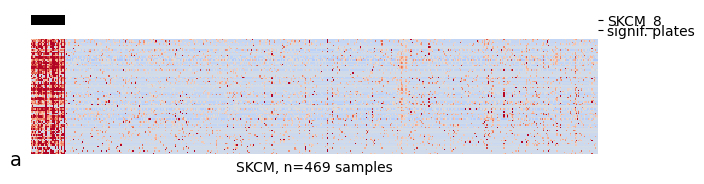

In [56]:
batch_type = "plate"
#batch_type_new = 'plates w. LIHC'
batch_type_new = 'signif. plates'
shared_samples = sorted(set(a.index).intersection(set(batches.index)))
a[batch_type] = "NA"
a.loc[shared_samples,batch_type] = batches.loc[shared_samples,batch_type]
color_dict[batch_type_new] = {}

all_batches_in_ds = sorted(set(a[batch_type].values))
#show_batches = with_lihc
#show_batches = sorted(set(df.loc[df["adj_pval"]<0.05,:].index))
#show_batches = sorted(["A37K","A311","A32O","A33R","A38B","A33J"])+["A41I"]
show_batches = sorted(["A352","A36H","A34F"])
color_dict[batch_type_new] = dict(zip(all_batches_in_ds,["white"]*len(all_batches_in_ds)))
color_dict[batch_type_new].update(dict(zip(show_batches,sns.color_palette("colorblind",len(show_batches)))))
# make white non-signif batches 
for b_id in show_batches:
    if b_id not in df.loc[df["adj_pval"]<0.05,:].index:
        color_dict[batch_type_new][b_id]="white"
a[batch_type_new] = a[batch_type]


from unpast.utils.figs import draw_heatmap2
row_labels = True

no_row_colors = True
if b.shape[0]>1:
    no_row_colors = False
tmp = draw_heatmap2(exprs_z ,b,
              bicluster_colors= "black",
              annot= a.loc[:,[batch_type_new]].copy(),
              color_dict = color_dict,
              figsize = (7,1.75), 
              dendrogram_ratio=(0.01,0.01),
              colors_ratio=(0.0, 0.07),
              bic_prefix = "",
              xlabel='%s, n=%s samples'%(cancer,exprs.shape[1]),
              highlight_row_labels=pancan.loc[259,"genes"],
              no_cbar=True,
              col_labels = False,
              #row_labels = row_labels,
              no_row_colors = no_row_colors,
              cluster_rows=False,
                   )

tmp[0].ax_heatmap.set_yticklabels(tmp[0].ax_heatmap.get_yticklabels(),fontdict={"size":6})
    
if b.shape[0]>1 or not no_row_colors:
    tmp[0].ax_row_colors.set_xticklabels(["",""])
    tmp[0].ax_row_colors.set_xticks([])    
tmp[0].fig.text(0.0, 0.0, "a", ha='left', va='bottom', fontsize=14)

### Plot signatures in many cancers and check batches

In [58]:
batch_type = "plate"
all_batches = set(batches[batch_type].values)
with_lihc = []
for b_id in all_batches:
    d  = batches.loc[batches[batch_type]==b_id,[batch_type,"project.project_id"]]
    if "TCGA-LIHC" in d["project.project_id"].values:
        with_lihc.append(b_id)
    #print(pl)
    #print(d.groupby("project.project_id").agg("count"))
len(all_batches), len(with_lihc)
print(with_lihc)

['A37K', 'A352', 'A155', 'A180', 'A32O', 'A311', 'A33R', 'A39D', 'A266', 'A33J', 'A27V', 'A41C', 'A28V', 'A38B', 'A36F', 'A22L', 'A16W', 'A131', 'A213']


ACC SnoRNA 4 samples 5.19% 	SNR=2.07
BLCA SnoRNA 15 samples 3.69% 	SNR=1.87
BRCA SnoRNA 18 samples 1.64% 	SNR=3.49
CESC SnoRNA 11 samples 3.59% 	SNR=1.80


/home/olya/anaconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


CHOL SnoRNA 1 samples 2.78% 	SNR=nan


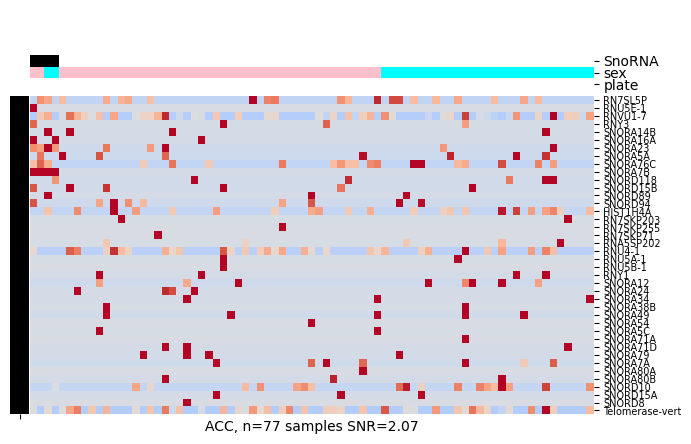

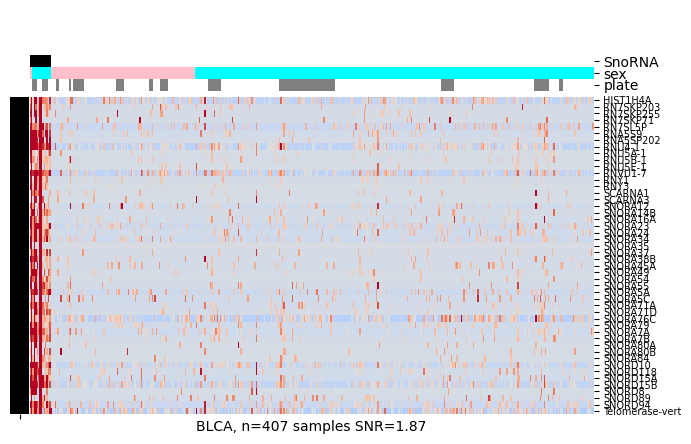

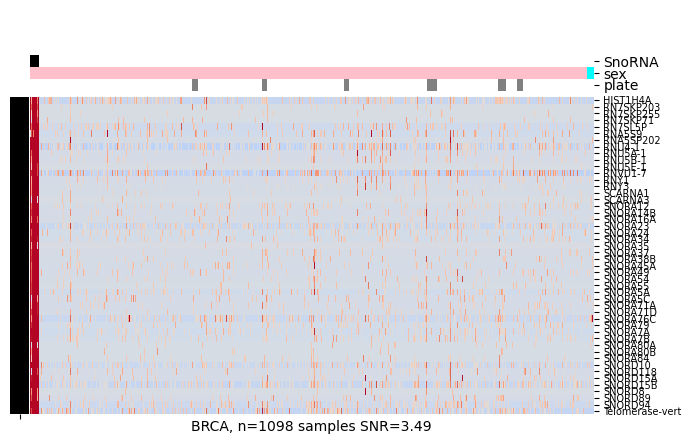

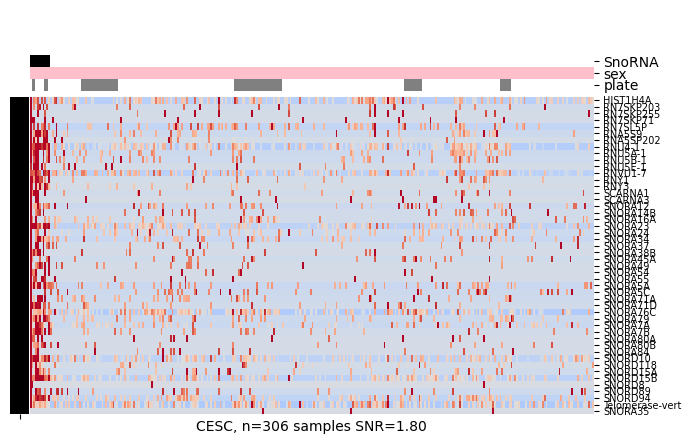

In [65]:
from unpast.utils.figs import draw_heatmap2
from unpast.utils.method import prepare_input_matrix, make_biclusters

cancers =  stats.index.values 
gene_sets = {#"hep-like":pancan.loc[259,"genes"],
             #'sex':pancan.loc[0,"genes"],
             #"B-cells":pancan.loc[26,"genes"],
             #"T-cells":pancan.loc[128,"genes"],
             "SnoRNA":pancan.loc[279,"genes"]
            }


#plot this signature in 5 cancers
for cancer in cancers[:5]:
    exprs = pd.read_csv(exprs_dir+cancer+".exprs.tsv.gz",index_col=0,sep="\t")
    exprs_z = prepare_input_matrix(exprs,ceiling=3)
    a = pd.read_csv(exprs_dir+"/"+cancer+".annotation.tsv.gz",index_col=0,sep="\t").loc[:,["sex"]]
    d1 = {1:"female",0:"male"}
    a = a.applymap(lambda x: d1[x])
    b = []
    for gs in gene_sets.keys():
        genes = gene_sets[gs].intersection(set(exprs_z.index.values))
        
        feature_clusters=[list(genes)]
        b_ = make_biclusters(feature_clusters,
                                         exprs_z.T,
                                         exprs_z,
                                         method = "kmeans",
                                         merge = 1,
                                         min_n_samples=1,
                                         min_n_genes=2,
                                         seed = analysis_seed,
                                         cluster_binary=False,
                                         verbose = True)
        b_.index = [gs]
        samples = b_.loc[gs,"samples"]
        print(cancer, gs, "%s samples %.2f"%(len(samples),len(samples)/exprs.shape[1]*100)+"%","\tSNR=%.2f"%b_["SNR"].values[0])
        b.append(b_)
    b = pd.concat(b)
    
    shared_samples = sorted(set(a.index).intersection(set(batches.index)))
    a[batch_type] = "NA"
    a.loc[shared_samples,batch_type] = batches.loc[shared_samples,batch_type]
    color_dict[batch_type] = {}
    for pl in set(a[batch_type].values):
        if pl in with_lihc:
            color_dict[batch_type][pl] = "grey"
        else:
            color_dict[batch_type][pl] = "white"
    
    if b["SNR"].values[0]>0.0:
        h = min(max(0.15*(b["n_genes"].sum()),3),5)
        row_labels = True
        if h>=8:
            row_labels = False
            h=8

        tmp = draw_heatmap2(exprs_z,
                            b,
                            bicluster_colors= "black",
                            annot= a.loc[:,["sex",batch_type]].copy(),
                            color_dict = color_dict,
                            figsize = (8,h), 
                            dendrogram_ratio=(0.1,0.1),
                            colors_ratio=(0.03, 0.15/h),
                            bic_prefix = "",
                            xlabel='%s, n=%s samples'%(cancer,exprs.shape[1])+" SNR=%.2f"%b["SNR"].values[0],
                            highlight_row_labels=pancan.loc[0,"genes"],
                            no_cbar=True,
                            col_labels = False,
                            row_labels = row_labels,
                            no_row_colors = False,
                            cluster_rows=False,
                       )
        if h>1 and h<20:
            tmp[0].ax_heatmap.set_yticklabels(tmp[0].ax_heatmap.get_yticklabels(),fontdict={"size":7})
        tmp[0].ax_row_colors.set_xticklabels([""]*b.shape[0])

### check association with batches

THCA SNR: [2.035435433472817] [21] [4.1015625] %


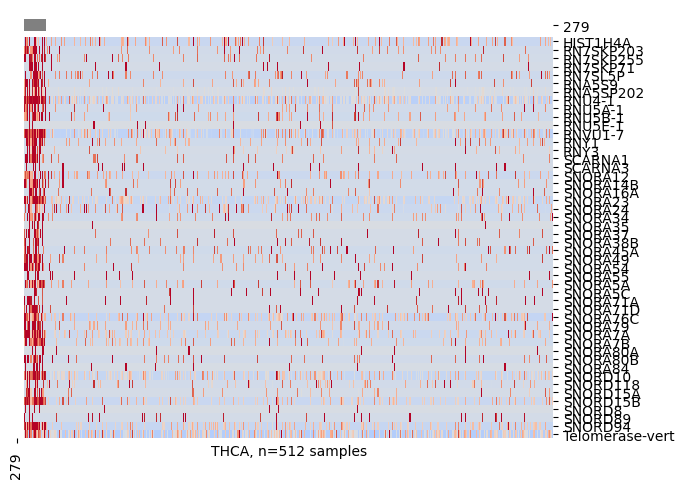

THYM SNR: [1.4819873977179114] [20] [16.80672268907563] %


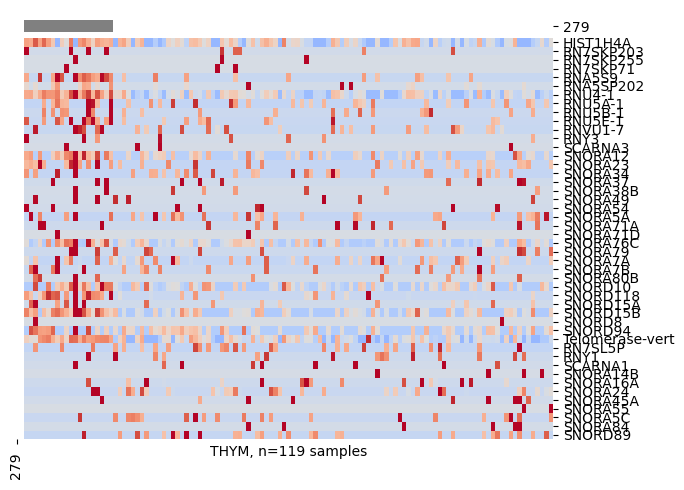

UCEC SNR: [16.273573087136306] [4] [2.209944751381215] %
bicluster: 4
         p_val    OR    o  plate  adj_pval
A118  0.002177  87.5  2.0    4.0  0.043542
bicluster: 4
       p_val   OR    o   TSS  adj_pval
BK  0.000005  inf  4.0  10.0  0.000141
bicluster: 4
            p_val     OR    o  batch_id  adj_pval
92.88.0  0.001097  176.0  2.0       3.0  0.026322
bicluster: 4
               p_val    OR    o  ship_date  adj_pval
2011-01-18  0.002177  87.5  2.0        4.0  0.043542


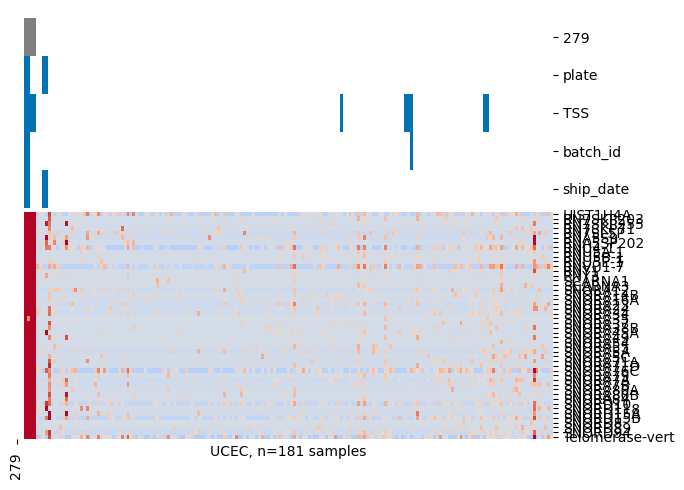

/home/olya/anaconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


UCS SNR: [nan] [1] [1.7543859649122806] %
	bicluster not found
UVM SNR: [1.300557743904958] [15] [18.9873417721519] %


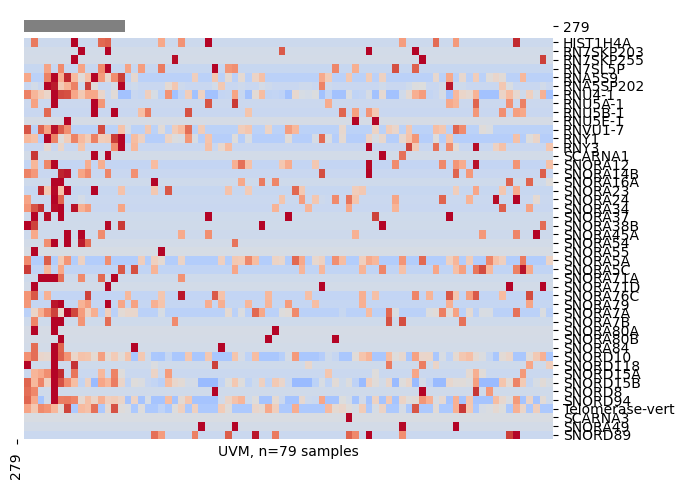

In [67]:
from unpast.utils.method import prepare_input_matrix, make_biclusters

# whether to load detected biclusters or make new based on gene sets
make_new_biclusters = True
# which batches to test
batches_to_check = ["plate","TSS","batch_id","ship_date","samples.preservation_method"]

### for B and T cell signatures
#cl_names = ["s26 (B cells)","s128 (T cells)"]
#make_new_biclusters =  False
#show_selected_features=['IL21','SPIC', 'TRAV1-1','TRAV2','TRBV10-1','TRBV2',
#                        'TRBV30','TRDV1','TRGV2','IGHV1-2','IGHV2-5','IGHV3-22',
#                        'IGHV6-1','IGKV1-6','IGKV3-7','IGLC6', 'IGLV4-3'] 
cl_names =[""]
show_selected_features = []

cl_id = [279]

confirmed = []
# run for five cancers 
for cancer in cancers[-5:]:
    exprs = pd.read_csv(exprs_dir+cancer+".exprs.tsv.gz",index_col=0,sep="\t")
    exprs_z = prepare_input_matrix(exprs,ceiling=3)
    if make_new_biclusters:
        feature_clusters = list(pancan.loc[cl_id,"genes"].apply(lambda x: sorted(x.intersection(exprs_z.index.values))).values)
        b = make_biclusters(feature_clusters,
                                         exprs_z.T,
                                         exprs_z,
                                         method = "kmeans",
                                         merge = 1,
                                         min_n_samples=1,
                                         min_n_genes=2,
                                         seed = analysis_seed,
                                         cluster_binary=False,
                                         verbose = True)
        b.index = cl_id
        #print(" ".join([x for x in b.loc[259,"samples"]]))
        #print(" ".join([x.split("-")[2] for x in b.loc[259,"samples"]]))
    else:
        # plot found biclusters 
        bic_file = bic_dir+cancer+"_consensus.seed="+str(analysis_seed)+suffix
        bics = read_bic_table(bic_file)
        bic_ids = []
        for x in reccurrent_bics.loc[cl_id,"biclusters"].apply(lambda row: [x for x in row if x.startswith(cancer)]).values:
            bic_ids+=x
        b = bics.loc[bic_ids,:]
    
    new_index = []
    for i in range(b.shape[0]):
        new_index.append(str(b.index.values[i])+" "+cl_names[i])
    b.index = new_index
    print(cancer, "SNR:",b["SNR"].values,
          b["n_samples"].values,
          b["n_samples"].values/exprs.shape[1]*100,"%")
    if b.loc[b["SNR"]>0,:].shape[0]>0:
        color_dict = {"sex":{"female":"pink","male":"cyan"}}
        confirmed.append(cancer)
        a = pd.read_csv(exprs_dir+"/"+cancer+".annotation.tsv.gz",index_col=0,sep="\t").loc[:,["sex"]]
        d1 = {1:"female",0:"male"}
        a = a.applymap(lambda x: d1[x])

        shared_samples = sorted(set(a.index).intersection(set(batches.index)))
        
        signif_v = []
        for v in batches_to_check: # batches to check
            a[v] = "NA"
            a.loc[shared_samples,v] = batches.loc[shared_samples,v]
            if len(set(a[v].values).difference(set(["NA"]))) > 1:
                for bic_id in b.index.values:
                    df = check_association_with_batch(b.loc[bic_id,"samples"],
                                                      annot=a,
                                                      batch_col=v)
                    signif_batches = sorted(df.loc[df["adj_pval"]<=0.05,:].index.values)
                    if len(signif_batches )>0:
                        print("bicluster:",b.loc[bic_id,"n_samples"])
                        if not v in signif_v:
                            signif_v.append(v)
                        print(df.loc[df["adj_pval"]<=0.05,:])
                        # colorblind-friendly palette for batches 
                        color_dict[v] = dict(zip(sorted(set(a[v].values)),["white"]*len(set(a[v].values))))
                        color_dict[v].update(dict(zip(signif_batches,sns.color_palette("colorblind", len(signif_batches)))))

        a = a.loc[:,signif_v]    
        
        no_row_colors = True
        cr = 0
        if b.shape[0]>1:
            cr = 0.01*(1+b.shape[0])
            no_row_colors = False
        tmp = draw_heatmap2(exprs_z,
                            b,
                  bicluster_colors= ["grey","black"],
                  annot= a.loc[:,:].copy(),
                  color_dict = color_dict,
                  figsize = (7,5), 
                  dendrogram_ratio=(0.01,0.01),
                  colors_ratio=(cr, 0.015*(1+len(signif_v)+b.shape[0])),
                  bic_prefix = "",
                  xlabel='%s, n=%s samples'%(cancer,exprs.shape[1]),
                  #highlight_row_labels=pancan.loc[128,"genes"],
                  no_cbar=True,
                  col_labels = False,
                  row_labels = True,
                  no_row_colors = False,
                  cluster_rows=False,
                       )
        new_yticks = []
        if b["n_genes"].sum()>50:
            if len(show_selected_features)>0:
                new_ylables = []
                
                for l,t in zip(tmp[0].ax_heatmap.get_yticklabels(),tmp[0].ax_heatmap.get_yticks()):
                    if l.get_text() in show_selected_features:
                        new_ylables.append(l)
                        new_yticks.append(t)
                    else:
                        new_ylables.append("")
            else:
                new_ylables = tmp[0].ax_heatmap.get_yticklabels()
            tmp[0].ax_heatmap.set_yticklabels(new_ylables,fontdict={"size":7})
            tmp[0].ax_heatmap.set_yticks(new_yticks)
    else:
        print("\tbicluster not found")
    #
    if b.shape[0]>1 and not no_row_colors:
        tmp[0].ax_row_colors.set_xticklabels([""]*b.shape[0])
        tmp[0].ax_row_colors.set_xticks([])
    #tmp[0].fig.text(0.02, 0.35, "a", ha='left', va='bottom', fontsize=18) HNSC
    #tmp[0].fig.text(0.02, 0.33, "b", ha='left', va='bottom', fontsize=18) OV_984
    #plt.tight_layout()
    plt.show()

# Gene Set Over-representaton Analysis

In [ ]:
import gseapy
#help(gseapy.get_library)
#help(gseapy.enrich)

In [ ]:
list(reccurrent_bics.index.values)

In [ ]:
bg_gene_names = sorted(passed_ids)
print("Background:", len(bg_gene_names))

## EnrichR gene sets
(slow)

In [ ]:
names = gseapy.get_library_name()
# names
gset_db_names = ['GO_Molecular_Function_2023','GO_Biological_Process_2023',
            'Reactome_Pathways_2024','KEGG_2021_Human','WikiPathways_2024_Human',
            'CellMarker_2024','Descartes_Cell_Types_and_Tissue_2021','Tabula_Sapiens']

gset_db_names = ['GO_Molecular_Function_2025', 
            'GO_Biological_Process_2025',
            'Reactome_Pathways_2024',
            'KEGG_2021_Human',
            'CORUM',
            'GTEx_Tissues_V8_2023',
            'CellMarker_2024',
            'Descartes_Cell_Types_and_Tissue_2021',
            'Tabula_Sapiens',
            'The_Kinase_Library_2024',
            'WikiPathways_2024_Human',
            'miRTarBase_2017','lncHUB_lncRNA_Co-Expression',
            'TF-LOF_Expression_from_GEO','TF_Perturbations_Followed_by_Expression',
            'TRANSFAC_and_JASPAR_PWMs','TRRUST_Transcription_Factors_2019',
            'Rummagene_kinases', 'Rummagene_signatures','Rummagene_transcription_factors',
            'RNAseq_Automatic_GEO_Signatures_Human_Down','RNAseq_Automatic_GEO_Signatures_Human_Up',
            'MSigDB_Hallmark_2020',
            'Kinase_Perturbations_from_GEO_down',
             'Kinase_Perturbations_from_GEO_up',
             'L1000_Kinase_and_GPCR_Perturbations_down',
             'L1000_Kinase_and_GPCR_Perturbations_up',
             'LINCS_L1000_CRISPR_KO_Consensus_Sigs',
             'LINCS_L1000_Chem_Pert_Consensus_Sigs',
             'LINCS_L1000_Chem_Pert_down',
             'LINCS_L1000_Chem_Pert_up',
             'LINCS_L1000_Ligand_Perturbations_down',
             'LINCS_L1000_Ligand_Perturbations_up',
             'Ligand_Perturbations_from_GEO_down',
             'Ligand_Perturbations_from_GEO_up',
             'Gene_Perturbations_from_GEO_down',
             'Gene_Perturbations_from_GEO_up',
             'DrugMatrix',
             'Drug_Perturbations_from_GEO_2014',
             'Drug_Perturbations_from_GEO_down',
             'Drug_Perturbations_from_GEO_up',
             'DGIdb_Drug_Targets_2024',
             'DSigDB'
]


print("Background:", len(bg_gene_names))

gset_db_list  = []
## download databases, extract datasets, overlap with background
for db_name in gset_db_names:
    gset_db = gseapy.get_library(name=db_name,
                                 organism ='Human',
                                 min_size = 2, 
                                 #max_size = 1000,
                                 gene_list= bg_gene_names)
    
    for gs in gset_db.keys():
        gset = gset_db[gs]
        gset_exprs =  sorted(set(gset).intersection(set(bg_gene_names)))
        if len(gset_db)>=2:
            gset_db[gs] = gset_exprs
    print(db_name, len(gset_db.keys()))
    
    gset_db_list.append(gset_db)

In [ ]:
#output_file = bic_dir+'recurrent_biclusters_GSOA_v2_17patterns_detailed.xlsx'
output_file = bic_dir+'recurrent_biclusters_GSOA_EnrichR_7patterns.xlsx'

with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
    # save recurrent biclusters and GSOA results to Excel
    rb = reccurrent_bics.loc[:,:].copy()
    rb.index = ["bic."+str(x) for x in rb.index]
    for col in ['gene_groups',"loc","genes","cancers","biclusters"]:
        rb[col] = rb[col].apply(lambda x: " ".join(sorted([elem for elem in x if not elem == ""])))
    rb.to_excel(writer, sheet_name="recurrent biclusters")
    # save recurrent biclusters and GSOA results to Excel
    # keep only signif. overlaps of size more than one
    for bic_id in list(reccurrent_bics.index.values):
        genes = sorted(pancan.loc[bic_id,"genes"])
        gp_output = gseapy.enrich(gene_list=genes,
                                   gene_sets=gset_db_list,
                                   background=bg_gene_names,
                                   outdir=None,
                                   no_plot=True
                                  )
        res = gp_output.results
        res["shared_genes"] = res["Genes"].apply(lambda x: set(x.split(";")))
        res["overlap"] = res["shared_genes"].apply(lambda x: len(x))
        res["shared_genes"] = res["shared_genes"].apply(lambda x : " ".join(sorted(x)))
        res["gene_set_collection"] = res["Gene_set"].apply(lambda x: gset_db_names[int(x.replace("gs_ind_",""))])
        res["db_gene_set_size"] = res["Overlap"].apply(lambda x: int(x.split("/")[1]))
        res["gene_set"] = res["Term"]
        cols = ["gene_set_collection","gene_set","overlap","shared_genes","db_gene_set_size"]
        cols2 = ["P-value","Adjusted P-value","Odds Ratio","Combined Score"]
        res = res.loc[res["overlap"]>1,cols+cols2]
        res = res.loc[res["Adjusted P-value"]<0.05,:]
        
        print("bic.%s, %s signif. gene set overlaps"%(bic_id,res.shape[0]))
        if res.shape[0]>0:
            res_condensed = []
            for db_name in set(res["gene_set_collection"].values):
                df = res.loc[res["gene_set_collection"]==db_name,:]
                for sg in set(df["shared_genes"].values):
                    # store only one hit per DB, with lowest p-val
                    res_condensed.append(df.loc[df["shared_genes"]==sg,:].sort_values("Adjusted P-value").head(1))
            res_condensed = pd.concat(res_condensed)
            res_condensed = res_condensed.sort_values(by = ["Combined Score","shared_genes"], ascending=[False,True])
        else:
            res_condensed = res.loc[:,:].copy()
        res_condensed.to_excel(writer, sheet_name="bic."+str(bic_id), index=False)

## MSigDB

In [ ]:
from gseapy import Msigdb
msig = Msigdb()
#msig.list_dbver()
dbver = "2024.1.Hs"
gset_db_names = msig.list_category(dbver=dbver)
gset_db_names = ["h.all",
                 #"c1.all",
                 "c2.all",
                 "c3.mir","c3.tft",
                 "c4.all",
                 "c5.go.mf","c5.go.bp","c5.go.cc","c5.hpo",
                 "c6.all",
                 "c7.all",
                 "c8.all"]

print("Background:", len(bg_gene_names))
gset_db_list = []
for db_name in gset_db_names:
    gset_db = msig.get_gmt(category=db_name, dbver=dbver)
    for gs in gset_db.keys():
        gset = gset_db[gs]
        gset_exprs =  sorted(set(gset).intersection(set(bg_gene_names)))
        if len(gset_db)>=2:
            gset_db[gs] = gset_exprs
    print(db_name, len(gset_db.keys()))
    gset_db_list.append(gset_db)

In [ ]:
#output_file = bic_dir+'recurrent_biclusters_GSOA_MSigDB_17patterns.xlsx'
output_file = bic_dir+'recurrent_biclusters_GSOA_MSigDB_7patterns.xlsx'

with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
    # save recurrent biclusters and GSOA results to Excel
    rb = reccurrent_bics.loc[:,:].copy()
    rb.index = ["bic."+str(x) for x in rb.index]
    for col in ['gene_groups',"loc","genes","cancers","biclusters"]:
        rb[col] = rb[col].apply(lambda x: " ".join(sorted([elem for elem in x if not elem == ""])))
    rb.to_excel(writer, sheet_name="recurrent biclusters")
    # save recurrent biclusters and GSOA results to Excel
    # keep only signif. overlaps of size more than one
    for bic_id in list(reccurrent_bics.index.values):
        genes = sorted(pancan.loc[bic_id,"genes"])
        gp_output = gseapy.enrich(gene_list=genes,
                                   gene_sets=gset_db_list,
                                   background=bg_gene_names,
                                   #cutoff = 0.05,
                                   outdir=None,
                                   no_plot=True
                                  )
        res = gp_output.results
        res["shared_genes"] = res["Genes"].apply(lambda x: set(x.split(";")))
        res["overlap"] = res["shared_genes"].apply(lambda x: len(x))
        res["shared_genes"] = res["shared_genes"].apply(lambda x : " ".join(sorted(x)))
        res["gene_set_collection"] = res["Gene_set"].apply(lambda x: gset_db_names[int(x.replace("gs_ind_",""))])
        res["db_gene_set_size"] = res["Overlap"].apply(lambda x: int(x.split("/")[1]))
        res["gene_set"] = res["Term"]
        cols = ["gene_set_collection","gene_set","overlap","shared_genes","db_gene_set_size"]
        cols2 = ["P-value","Adjusted P-value","Odds Ratio","Combined Score"]
        res = res.loc[res["overlap"]>1,cols+cols2]
        res = res.loc[res["Adjusted P-value"]<0.05,:]
        
        print("bic.%s, %s signif. gene set overlaps"%(bic_id,res.shape[0]))
        if res.shape[0]>0:
            
            res_condensed = []
            for db_name in set(res["gene_set_collection"].values):
                df = res.loc[res["gene_set_collection"]==db_name,:]
                for sg in set(df["shared_genes"].values):
                    # store only one hit per DB, with lowest p-val
                    res_condensed.append(df.loc[df["shared_genes"]==sg,:].sort_values("Adjusted P-value").head(1))
            res_condensed = pd.concat(res_condensed)
            res_condensed = res_condensed.sort_values(by = ["Combined Score","shared_genes"], ascending=[False,True])
        else:
            res_condensed = res.loc[:,:].copy()
        res_condensed.to_excel(writer, sheet_name="bic."+str(bic_id), index=False)

### cancer similarity

In [ ]:
cancers = stats.index.values
color_dict = {}
for c in cancers:
    if c in ento:
        color_dict[c]="green"
    elif c in ecto:
        color_dict[c] = "yellow"
    elif c in meso:
        color_dict[c] = "red"
    else:
        color_dict[c] = "grey"
color_dict = pd.DataFrame.from_dict({"germ layer":color_dict})
pangyn = ["OV","UCEC","CESC","UCS","BRCA"]

In [ ]:
cancer_sim = {}
x = pancan.loc[pancan["n_groups"]>1,:].loc[pancan["n_loc"]>1,:].loc[pancan["n_genes"]>=10,:]

for row in x.iterrows():
    m = row[0]
    c = row[1]["cancers"]
    cancer_sim[m] = dict(zip(c,np.ones(len(c))))
cancer_sim = pd.DataFrame.from_dict(cancer_sim).T
cancer_sim = cancer_sim.fillna(0)
sns.clustermap(cancer_sim ,annot = False,figsize=(10,10), 
               col_colors=color_dict,
               row_cluster = False)